<a href="https://colab.research.google.com/github/AhmedYounes94/AraBERT-Diacritic-experiment/blob/Adding-Diacritics-to-all-data/AraBERTv2_ANERCorp_Undiacritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We are using ANERCorp with Camel splits

The first part uses the Trainer API to quickly train the model


The second part defines a custom model and training loop which should be identical



**For AraBERTv1 and V2 you need to use the custom scripts** since the datasets library with the pyarrow backend dont support using farasapy

In [2]:
!pip install transformers
!pip install datasets
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 3.2MB 51.3MB/s 
     |████████████████████████████████| 890kB 43.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=8c2f5f80ad30da0897e2685ac4ed164c6b41985e05979401ca0c306b2e5db733
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 4.1MB/s 
     |████████████████████████████████| 245kB 38.1MB/s 
     |████████████████████████████████| 112kB 35.6MB/s 
     |████████████████████████████████| 20.7MB 1.5MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 112kB 5.6MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp37-none-any.whl size=113324 sha256=fb5f7080f1bae24340e12cb714d2f98fb7d6be19

In [3]:
# !unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

#Reading Data

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
ANERCorp_path = '/content/drive/My Drive/data/'

excel_data = pd.read_excel(ANERCorp_path+'Final_ANERCorp.xlsx')
train, test = train_test_split(excel_data)
np.savetxt(ANERCorp_path+'Train.txt', train.values, fmt='%s' )
np.savetxt(ANERCorp_path+'Test.txt', test.values, fmt='%s' )

In [4]:
# !head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line.split()[0]=='.':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [28]:
ANERCorp_path = '/content/drive/My Drive/data/'
# data_train = read_ANERcorp(ANERCorp_path+'diacritic_train.txt')
# data_test = read_ANERcorp(ANERCorp_path+'diacritic_test.txt')
data_train = read_ANERcorp(ANERCorp_path+'Train.txt')
data_test = read_ANERcorp(ANERCorp_path+'Test.txt')
data_all = read_ANERcorp(ANERCorp_path+'ANERCorp.txt')


In [30]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 28350, 'B-LOC': 1078, 'B-PERS': 847, 'I-PERS': 627, 'B-ORG': 509, 'I-ORG': 311, 'B-MISC': 250, 'I-LOC': 141, 'I-MISC': 116})
Counter({'O': 84996, 'B-LOC': 3191, 'B-PERS': 2593, 'I-PERS': 2075, 'B-ORG': 1405, 'I-ORG': 987, 'B-MISC': 820, 'I-LOC': 445, 'I-MISC': 352})


In [31]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-LOC', 'B-PERS', 'B-ORG', 'I-PERS', 'I-ORG', 'I-MISC', 'B-MISC', 'I-LOC']


Training Sentence Lengths: 


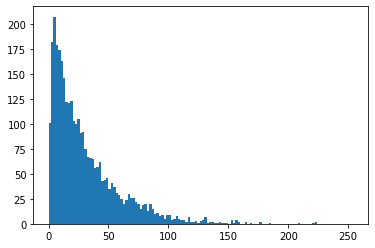

0
Testing Sentence Lengths: 


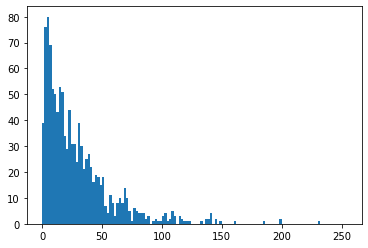

0


In [32]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#NER with Trainer

In [33]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py

--2021-02-24 12:27:51--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19188 (19K) [text/plain]
Saving to: ‘run_ner.py.1’

run_ner.py.1        100%[===================>]  18.74K  --.-KB/s    in 0.001s  

2021-02-24 12:27:52 (24.0 MB/s) - ‘run_ner.py.1’ saved [19188/19188]



Converting data to huggingface supported format
1 json per line with "tokens" and "ner_tags" as keys

close to this for format https://github.com/huggingface/transformers/blob/master/tests/fixtures/tests_samples/conll/sample.json

In [34]:
import json

with open("train_data.json", "w") as outfile:
  for examples in data_train:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

with open("test_data.json", "w") as outfile:
  for examples in data_test:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

In [35]:
# !python run_ner.py \
#   --model_name_or_path aubmindlab/bert-large-arabertv02 \
#   --train_file train_data.json \
#   --validation_file test_data.json \
#   --output_dir ./test-ner \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 4 \
#   --gradient_accumulation_steps 8 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 10 \
#   --warmup_steps 0 \
#   --evaluation_strategy epoch \
#   --save_steps 10000 \
#   --overwrite_output_dir \
#   --seed 42 \
#   --fp16 \

#NER with custom Model

##Model Files

In [36]:
from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess import ArabertPreprocessor, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [37]:
MAX_SEQ_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
accumulation_steps = 1


#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv02'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)
arabert_prep = ArabertPreprocessor(BASE_MODEL_PATH.split("/")[-1])

In [38]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


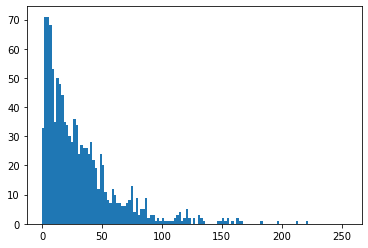

23


In [39]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(arabert_prep.preprocess(" ".join(sentence[0]))) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > MAX_SEQ_LEN for x in tokenized_data]))

In [40]:
class NERDataset:
  def __init__(self, texts, tags, label_list, preprocessor):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = preprocessor    
    self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = TOKENIZER.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(attention_mask) == MAX_SEQ_LEN
    assert len(token_type_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [41]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(self.bert.config.hidden_size, self.num_tag)
 
    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,output_hidden_states=True)
        bo_tag = self.bert_drop(output['last_hidden_state'])
        logits = self.out_tag(bo_tag)

        loss_tag = loss_fn(logits, labels, attention_mask, self.num_tag)
        return loss_tag, logits

In [42]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions,label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [43]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for i, data in enumerate(tqdm(data_loader, total=len(data_loader))):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        loss.backward()
        final_loss += loss.item()
        if (i + 1 ) % accumulation_steps == 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
          optimizer.step()
          scheduler.step()          
          optimizer.zero_grad()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      labels = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        logits = outputs[1]
        final_loss += loss.item()
        if logits is not None:        
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['labels'] is not None:
          labels = data['labels'] if labels is None else torch.cat((labels, data['labels']), dim=0)

      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()     
    
    return compute_metrics(preds,labels), final_loss

In [44]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Wed Feb 24 12:28:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                

##Cross_validation Loop


In [46]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=False, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    preprocessor=arabert_prep)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [ ]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(data_train)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_train[x] for x in train]],
    tags = [x[1] for x in [data_train[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  dev_dataset = NERDataset(
      texts= [x[0] for x in [ data_train[x] for x in dev]],
      tags = [x[1] for x in [ data_train[x] for x in dev]],
      label_list = label_list,
      preprocessor=arabert_prep)

  dev_dataloader = torch.utils.data.DataLoader(
      dataset=dev_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )

  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )
  
  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(dev_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
      if eval_metrics['f1'] > fold_best_f1:
        print('New Best Model Found!')
        torch.save(model.state_dict(), MODEL_PATH)
        fold_best_f1 = eval_metrics['f1']
        best_fold = fold_num

Starting Fold Num:  0



MODEL LOADED!
Number of training steps:  868


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.9158    0.8997    0.9077       907
        MISC     0.8252    0.5414    0.6538       157
         ORG     0.7600    0.7066    0.7323       242
        PERS     0.8993    0.9291    0.9140       423

   micro avg     0.8847    0.8473    0.8656      1729
   macro avg     0.8501    0.7692    0.8020      1729
weighted avg     0.8818    0.8473    0.8616      1729

Train Loss = 0.38109938200327687 Valid Loss = 9.008640499319881
{'accuracy_score': 0.9731211989574283, 'precision': 0.8846618357487923, 'recall': 0.8473105841526894, 'f1': 0.8655834564254062}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9340    0.8732    0.9026       907
        MISC     0.7045    0.5924    0.6436       157
         ORG     0.8246    0.7190    0.7682       242
        PERS     0.8989    0.9243    0.9114       423

   micro avg     0.8918    0.8386    0.8644      1729
   macro avg     0.8405    0.7772    0.8064      1729
weighted avg     0.8892    0.8386    0.8624      1729

Train Loss = 0.07290141377196616 Valid Loss = 8.922092444845475
{'accuracy_score': 0.9767050390964379, 'precision': 0.8917589175891759, 'recall': 0.838635049161365, 'f1': 0.8643815201192251}



              precision    recall  f1-score   support

         LOC     0.9204    0.9173    0.9188       907
        MISC     0.7089    0.7134    0.7111       157
         ORG     0.7373    0.7769    0.7565       242
        PERS     0.9274    0.9362    0.9318       423

   micro avg     0.8761    0.8837    0.8799      1729
   macro avg     0.8235    0.8359    0.8296      1729
weighted avg     0.8772    0.8837    0.8804      1729

Train Loss = 0.041908575124883406 Valid Loss = 7.954061987751629
{'accuracy_score': 0.9784969591659427, 'precision': 0.8761467889908257, 'recall': 0.8837478311162522, 'f1': 0.8799308954794126}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9283    0.9129    0.9205       907
        MISC     0.7681    0.6752    0.7186       157
         ORG     0.8333    0.7438    0.7860       242
        PERS     0.9108    0.9409    0.9256       423

   micro avg     0.8984    0.8745    0.8863      1729
   macro avg     0.8601    0.8182    0.8377      1729
weighted avg     0.8961    0.8745    0.8846      1729

Train Loss = 0.025674721823560995 Valid Loss = 9.042191668064333
{'accuracy_score': 0.9790399652476107, 'precision': 0.8983957219251337, 'recall': 0.8744939271255061, 'f1': 0.8862837045720986}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9269    0.9085    0.9176       907
        MISC     0.7413    0.6752    0.7067       157
         ORG     0.8235    0.7521    0.7862       242
        PERS     0.9114    0.9480    0.9293       423

   micro avg     0.8937    0.8751    0.8843      1729
   macro avg     0.8508    0.8209    0.8349      1729
weighted avg     0.8918    0.8751    0.8829      1729

Train Loss = 0.017616014327317336 Valid Loss = 9.173318146058591
{'accuracy_score': 0.979528670721112, 'precision': 0.893679858239811, 'recall': 0.8750722961249277, 'f1': 0.8842781998831093}
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  869



              precision    recall  f1-score   support

         LOC     0.8330    0.8860    0.8587       535
        MISC     0.3947    0.1103    0.1724       136
         ORG     0.7755    0.5481    0.6423       208
        PERS     0.9320    0.9131    0.9224       495

   micro avg     0.8515    0.7678    0.8075      1374
   macro avg     0.7338    0.6144    0.6490      1374
weighted avg     0.8166    0.7678    0.7810      1374

Train Loss = 0.4219395680106834 Valid Loss = 10.710909696586896
{'accuracy_score': 0.9668628605061801, 'precision': 0.8514931396287329, 'recall': 0.7678311499272198, 'f1': 0.807500956754688}



              precision    recall  f1-score   support

         LOC     0.8735    0.9421    0.9065       535
        MISC     0.6467    0.7132    0.6783       136
         ORG     0.6957    0.6154    0.6531       208
        PERS     0.9454    0.9091    0.9269       495

   micro avg     0.8500    0.8581    0.8540      1374
   macro avg     0.7903    0.7949    0.7912      1374
weighted avg     0.8500    0.8581    0.8529      1374

Train Loss = 0.07232187083526247 Valid Loss = 8.311548999452498
{'accuracy_score': 0.9751030017657446, 'precision': 0.8500360490266763, 'recall': 0.8580786026200873, 'f1': 0.8540383918869974}



              precision    recall  f1-score   support

         LOC     0.8700    0.9383    0.9029       535
        MISC     0.6688    0.7721    0.7167       136
         ORG     0.6904    0.6538    0.6716       208
        PERS     0.9378    0.9131    0.9253       495

   micro avg     0.8457    0.8697    0.8576      1374
   macro avg     0.7917    0.8193    0.8041      1374
weighted avg     0.8473    0.8697    0.8575      1374

Train Loss = 0.04080771266057252 Valid Loss = 8.615358903392917
{'accuracy_score': 0.9760447321954091, 'precision': 0.8457183297947629, 'recall': 0.8697234352256187, 'f1': 0.8575529242913528}



              precision    recall  f1-score   support

         LOC     0.8799    0.9308    0.9046       535
        MISC     0.7008    0.6544    0.6768       136
         ORG     0.7849    0.6490    0.7105       208
        PERS     0.9480    0.9212    0.9344       495

   micro avg     0.8752    0.8574    0.8662      1374
   macro avg     0.8284    0.7889    0.8066      1374
weighted avg     0.8723    0.8574    0.8634      1374

Train Loss = 0.024001890419609043 Valid Loss = 9.640210337245662
{'accuracy_score': 0.9775750441436138, 'precision': 0.87518573551263, 'recall': 0.8573508005822417, 'f1': 0.8661764705882353}



              precision    recall  f1-score   support

         LOC     0.8633    0.9327    0.8967       535
        MISC     0.6641    0.6397    0.6517       136
         ORG     0.7602    0.6250    0.6860       208
        PERS     0.9462    0.9232    0.9346       495

   micro avg     0.8606    0.8537    0.8571      1374
   macro avg     0.8085    0.7802    0.7922      1374
weighted avg     0.8578    0.8537    0.8542      1374

Train Loss = 0.016352756871191528 Valid Loss = 10.19970623331028
{'accuracy_score': 0.9760447321954091, 'precision': 0.8606016140865738, 'recall': 0.8537117903930131, 'f1': 0.8571428571428571}
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  869



              precision    recall  f1-score   support

         LOC     0.8754    0.9014    0.8882       639
        MISC     0.4380    0.3681    0.4000       144
         ORG     0.4261    0.4016    0.4135       122
        PERS     0.8667    0.7860    0.8244       430

   micro avg     0.7913    0.7610    0.7759      1335
   macro avg     0.6515    0.6143    0.6315      1335
weighted avg     0.7843    0.7610    0.7716      1335

Train Loss = 0.4366852649508965 Valid Loss = 7.8806247231550515
{'accuracy_score': 0.9776754075124026, 'precision': 0.7912772585669782, 'recall': 0.7610486891385768, 'f1': 0.7758686521573119}



              precision    recall  f1-score   support

         LOC     0.8925    0.9092    0.9008       639
        MISC     0.4658    0.5208    0.4918       144
         ORG     0.6163    0.4344    0.5096       122
        PERS     0.8875    0.8256    0.8554       430

   micro avg     0.8197    0.7970    0.8082      1335
   macro avg     0.7155    0.6725    0.6894      1335
weighted avg     0.8196    0.7970    0.8063      1335

Train Loss = 0.07263168465913455 Valid Loss = 7.257175668841228
{'accuracy_score': 0.9793586109142453, 'precision': 0.8197226502311248, 'recall': 0.797003745318352, 'f1': 0.808203570072161}



              precision    recall  f1-score   support

         LOC     0.8908    0.9061    0.8984       639
        MISC     0.4150    0.5764    0.4826       144
         ORG     0.4082    0.4918    0.4461       122
        PERS     0.8979    0.7977    0.8448       430

   micro avg     0.7723    0.7978    0.7848      1335
   macro avg     0.6530    0.6930    0.6680      1335
weighted avg     0.7976    0.7978    0.7949      1335

Train Loss = 0.04289747974614549 Valid Loss = 8.233892983058468
{'accuracy_score': 0.9774096385542169, 'precision': 0.7722987672226251, 'recall': 0.797752808988764, 'f1': 0.78481945467944}



              precision    recall  f1-score   support

         LOC     0.8977    0.9061    0.9019       639
        MISC     0.5556    0.4861    0.5185       144
         ORG     0.5096    0.4344    0.4690       122
        PERS     0.8511    0.7977    0.8235       430

   micro avg     0.8177    0.7828    0.7998      1335
   macro avg     0.7035    0.6561    0.6782      1335
weighted avg     0.8103    0.7828    0.7957      1335

Train Loss = 0.026329066328056712 Valid Loss = 8.177410970121855
{'accuracy_score': 0.9791371367824239, 'precision': 0.8176838810641628, 'recall': 0.7827715355805244, 'f1': 0.7998469192499044}



              precision    recall  f1-score   support

         LOC     0.8940    0.9108    0.9023       639
        MISC     0.4928    0.4722    0.4823       144
         ORG     0.5000    0.4508    0.4741       122
        PERS     0.8685    0.8140    0.8403       430

   micro avg     0.8103    0.7903    0.8002      1335
   macro avg     0.6888    0.6619    0.6748      1335
weighted avg     0.8065    0.7903    0.7979      1335

Train Loss = 0.01666400952655394 Valid Loss = 8.28019064500404
{'accuracy_score': 0.9793586109142453, 'precision': 0.8102918586789555, 'recall': 0.7902621722846442, 'f1': 0.8001516875237012}
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  869



              precision    recall  f1-score   support

         LOC     0.8596    0.8653    0.8625       750
        MISC     0.5299    0.3669    0.4336       169
         ORG     0.7582    0.7273    0.7424       319
        PERS     0.9240    0.9110    0.9175       427

   micro avg     0.8330    0.8000    0.8162      1665
   macro avg     0.7679    0.7176    0.7390      1665
weighted avg     0.8232    0.8000    0.8100      1665

Train Loss = 0.4141777718958884 Valid Loss = 9.457034258870408
{'accuracy_score': 0.9705468435866506, 'precision': 0.8330206378986866, 'recall': 0.8, 'f1': 0.8161764705882353}



              precision    recall  f1-score   support

         LOC     0.8678    0.8840    0.8758       750
        MISC     0.6081    0.5325    0.5678       169
         ORG     0.7493    0.8433    0.7935       319
        PERS     0.9258    0.9344    0.9301       427

   micro avg     0.8349    0.8535    0.8441      1665
   macro avg     0.7877    0.7986    0.7918      1665
weighted avg     0.8336    0.8535    0.8427      1665

Train Loss = 0.0711721819383895 Valid Loss = 7.91984739335021
{'accuracy_score': 0.976427422597507, 'precision': 0.8349001175088132, 'recall': 0.8534534534534535, 'f1': 0.8440748440748441}



              precision    recall  f1-score   support

         LOC     0.8472    0.8800    0.8633       750
        MISC     0.6296    0.6036    0.6163       169
         ORG     0.7023    0.8433    0.7664       319
        PERS     0.9354    0.9157    0.9254       427

   micro avg     0.8163    0.8541    0.8348      1665
   macro avg     0.7787    0.8106    0.7929      1665
weighted avg     0.8200    0.8541    0.8356      1665

Train Loss = 0.03761905736501339 Valid Loss = 8.644195793371182
{'accuracy_score': 0.9747687977482911, 'precision': 0.8163030998851895, 'recall': 0.8540540540540541, 'f1': 0.8347519812151452}



              precision    recall  f1-score   support

         LOC     0.8855    0.8973    0.8914       750
        MISC     0.6159    0.5503    0.5813       169
         ORG     0.7692    0.8150    0.7915       319
        PERS     0.9360    0.9251    0.9305       427

   micro avg     0.8504    0.8535    0.8519      1665
   macro avg     0.8017    0.7969    0.7987      1665
weighted avg     0.8488    0.8535    0.8508      1665

Train Loss = 0.0233374840580596 Valid Loss = 9.133549070073059
{'accuracy_score': 0.9770305589063129, 'precision': 0.8503889886295631, 'recall': 0.8534534534534535, 'f1': 0.8519184652278177}



              precision    recall  f1-score   support

         LOC     0.8804    0.9027    0.8914       750
        MISC     0.6739    0.5503    0.6059       169
         ORG     0.7861    0.8527    0.8180       319
        PERS     0.9322    0.9344    0.9333       427

   micro avg     0.8572    0.8655    0.8613      1665
   macro avg     0.8182    0.8100    0.8122      1665
weighted avg     0.8547    0.8655    0.8591      1665

Train Loss = 0.015324651553688956 Valid Loss = 9.025997970617027
{'accuracy_score': 0.9777342179332529, 'precision': 0.8572278405710886, 'recall': 0.8654654654654654, 'f1': 0.8613269575612672}
Starting Fold Num:  4
MODEL LOADED!
Number of training steps:  869



              precision    recall  f1-score   support

         LOC     0.9144    0.9355    0.9248       605
        MISC     0.5125    0.6089    0.5566       202
         ORG     0.7338    0.7375    0.7357       400
        PERS     0.8900    0.9097    0.8997       587

   micro avg     0.8157    0.8462    0.8306      1794
   macro avg     0.7627    0.7979    0.7792      1794
weighted avg     0.8209    0.8462    0.8330      1794

Train Loss = 0.39866797169456364 Valid Loss = 9.216001277556643
{'accuracy_score': 0.9721638386220331, 'precision': 0.815690488984417, 'recall': 0.8461538461538461, 'f1': 0.8306429548563611}



              precision    recall  f1-score   support

         LOC     0.9195    0.9438    0.9315       605
        MISC     0.6667    0.7030    0.6843       202
         ORG     0.7551    0.8250    0.7885       400
        PERS     0.9122    0.9199    0.9160       587

   micro avg     0.8497    0.8824    0.8657      1794
   macro avg     0.8134    0.8479    0.8301      1794
weighted avg     0.8520    0.8824    0.8667      1794

Train Loss = 0.07061843507810785 Valid Loss = 8.072143480472732
{'accuracy_score': 0.9769313579740606, 'precision': 0.8497047772410091, 'recall': 0.8823857302118172, 'f1': 0.86573694284933}



              precision    recall  f1-score   support

         LOC     0.9117    0.9388    0.9251       605
        MISC     0.6711    0.7475    0.7073       202
         ORG     0.7259    0.8275    0.7734       400
        PERS     0.9130    0.9114    0.9122       587

   micro avg     0.8386    0.8835    0.8605      1794
   macro avg     0.8054    0.8563    0.8295      1794
weighted avg     0.8436    0.8835    0.8625      1794

Train Loss = 0.03566587882266305 Valid Loss = 9.067310884885956
{'accuracy_score': 0.9740093299841083, 'precision': 0.8386243386243386, 'recall': 0.8835005574136009, 'f1': 0.8604777415852335}



              precision    recall  f1-score   support

         LOC     0.9235    0.9372    0.9303       605
        MISC     0.7190    0.7475    0.7330       202
         ORG     0.7828    0.8200    0.8010       400
        PERS     0.9116    0.9131    0.9123       587

   micro avg     0.8640    0.8818    0.8728      1794
   macro avg     0.8342    0.8545    0.8441      1794
weighted avg     0.8652    0.8818    0.8734      1794

Train Loss = 0.021080702287345675 Valid Loss = 8.600253150696517
{'accuracy_score': 0.9782642128466704, 'precision': 0.86400873839432, 'recall': 0.8818283166109253, 'f1': 0.8728275862068965}



              precision    recall  f1-score   support

         LOC     0.9210    0.9438    0.9322       605
        MISC     0.8242    0.6733    0.7411       202
         ORG     0.7882    0.8000    0.7940       400
        PERS     0.9007    0.9114    0.9060       587

   micro avg     0.8751    0.8707    0.8729      1794
   macro avg     0.8585    0.8321    0.8434      1794
weighted avg     0.8738    0.8707    0.8713      1794

Train Loss = 0.014684144046556354 Valid Loss = 8.931131255463697
{'accuracy_score': 0.9786743220382427, 'precision': 0.8750700280112045, 'recall': 0.8706800445930881, 'f1': 0.8728695166247556}


In [ ]:
print(fold_best_f1)
print(fold_num)

0.8862837045720986
4


In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))
test_metrics, test_loss = eval_fn(test_dataloader, model, device)
print(f"Test Loss = {test_loss}")
print(test_metrics)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8885    0.9549    0.9205       709
        MISC     0.7363    0.6167    0.6712       240
         ORG     0.7862    0.7338    0.7591       526
        PERS     0.9043    0.8801    0.8920       934

   micro avg     0.8603    0.8439    0.8521      2409
   macro avg     0.8288    0.7964    0.8107      2409
weighted avg     0.8571    0.8439    0.8494      2409

Test Loss = 20.838649787125178
{'accuracy_score': 0.9725362170985513, 'precision': 0.8603470165044435, 'recall': 0.8439186384391864, 'f1': 0.8520536462699076}


##Training on all the training data


In [49]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, test) in enumerate(kf.split(data_all)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_all[x] for x in train]],
    tags = [x[1] for x in [data_all[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  test_dataset = NERDataset(
      texts= [x[0] for x in [ data_all[x] for x in test]],
      tags = [x[1] for x in [ data_all[x] for x in test]],
      label_list = label_list,
      preprocessor=arabert_prep)

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )
  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )

  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
  # train_dataset = NERDataset(
  #     texts= [x[0] for x in data_train],
  #     tags = [x[1] for x in data_train],
  #     label_list = label_list,
  #     preprocessor=arabert_prep)

  # train_dataloader = torch.utils.data.DataLoader(
  #     dataset=train_dataset,
  #     batch_size=TRAIN_BATCH_SIZE,
  #     num_workers=2
  # )

  # test_dataset = NERDataset(
  #     texts= [x[0] for x in data_test],
  #     tags = [x[1] for x in data_test],
  #     label_list = label_list,
  #     preprocessor=arabert_prep)

  # test_dataloader = torch.utils.data.DataLoader(
  #     dataset=test_dataset,
  #     batch_size=VALID_BATCH_SIZE,
  #     num_workers=1
  # )

Starting Fold Num:  0



MODEL LOADED!
Number of training steps:  248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.7027    0.8553    0.7715       152
        MISC     0.0000    0.0000    0.0000        35
         ORG     0.5867    0.6331    0.6090       139
        PERS     0.8108    0.8955    0.8511       134

   micro avg     0.6998    0.7348    0.7169       460
   macro avg     0.5250    0.5960    0.5579       460
weighted avg     0.6457    0.7348    0.6869       460

Train Loss = 0.7600008851289749 Valid Loss = 3.767217095941305
{'accuracy_score': 0.962867457452295, 'precision': 0.6997929606625258, 'recall': 0.7347826086956522, 'f1': 0.7168610816542947}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         LOC     0.8543    0.8487    0.8515       152
        MISC     0.6000    0.3429    0.4364        35
         ORG     0.7246    0.7194    0.7220       139
        PERS     0.8955    0.8955    0.8955       134

   micro avg     0.8149    0.7848    0.7996       460
   macro avg     0.7686    0.7016    0.7263       460
weighted avg     0.8078    0.7848    0.7936       460

Train Loss = 0.17870402835309507 Valid Loss = 2.5959464532788843
{'accuracy_score': 0.9738696922812446, 'precision': 0.8148984198645598, 'recall': 0.7847826086956522, 'f1': 0.7995570321151717}



              precision    recall  f1-score   support

         LOC     0.8447    0.8947    0.8690       152
        MISC     0.5806    0.5143    0.5455        35
         ORG     0.7568    0.8058    0.7805       139
        PERS     0.9237    0.9030    0.9132       134

   micro avg     0.8217    0.8413    0.8314       460
   macro avg     0.7764    0.7794    0.7770       460
weighted avg     0.8210    0.8413    0.8305       460

Train Loss = 0.08599064640700817 Valid Loss = 2.557888652663678
{'accuracy_score': 0.9745573319580539, 'precision': 0.821656050955414, 'recall': 0.841304347826087, 'f1': 0.8313641245972073}



              precision    recall  f1-score   support

         LOC     0.8434    0.9211    0.8805       152
        MISC     0.6786    0.5429    0.6032        35
         ORG     0.7730    0.7842    0.7786       139
        PERS     0.9098    0.9030    0.9064       134

   micro avg     0.8312    0.8457    0.8384       460
   macro avg     0.8012    0.7878    0.7922       460
weighted avg     0.8289    0.8457    0.8361       460

Train Loss = 0.06297062665224075 Valid Loss = 2.55564404418692
{'accuracy_score': 0.975073061715661, 'precision': 0.8311965811965812, 'recall': 0.8456521739130435, 'f1': 0.8383620689655172}



              precision    recall  f1-score   support

         LOC     0.8424    0.9145    0.8770       152
        MISC     0.6552    0.5429    0.5937        35
         ORG     0.7857    0.7914    0.7885       139
        PERS     0.9167    0.9030    0.9098       134

   micro avg     0.8348    0.8457    0.8402       460
   macro avg     0.8000    0.7879    0.7923       460
weighted avg     0.8327    0.8457    0.8383       460

Train Loss = 0.03826056638266891 Valid Loss = 2.553572869859636
{'accuracy_score': 0.975588791473268, 'precision': 0.8347639484978541, 'recall': 0.8456521739130435, 'f1': 0.8401727861771059}
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  248



              precision    recall  f1-score   support

         LOC     0.7188    0.8333    0.7718       138
        MISC     0.0000    0.0000    0.0000        72
         ORG     0.3939    0.4771    0.4315       109
        PERS     0.8447    0.8246    0.8345       211

   micro avg     0.6847    0.6434    0.6634       530
   macro avg     0.4893    0.5338    0.5095       530
weighted avg     0.6044    0.6434    0.6220       530

Train Loss = 0.7937388432025909 Valid Loss = 8.730245493352413
{'accuracy_score': 0.9319158561411446, 'precision': 0.6847389558232931, 'recall': 0.6433962264150943, 'f1': 0.6634241245136187}



              precision    recall  f1-score   support

         LOC     0.8767    0.9275    0.9014       138
        MISC     0.4500    0.1250    0.1957        72
         ORG     0.7561    0.5688    0.6492       109
        PERS     0.8524    0.8483    0.8504       211

   micro avg     0.8253    0.7132    0.7652       530
   macro avg     0.7338    0.6174    0.6492       530
weighted avg     0.7843    0.7132    0.7333       530

Train Loss = 0.13617264833301307 Valid Loss = 7.684780279174447
{'accuracy_score': 0.9493327301515494, 'precision': 0.8253275109170306, 'recall': 0.7132075471698113, 'f1': 0.7651821862348177}



              precision    recall  f1-score   support

         LOC     0.8889    0.9275    0.9078       138
        MISC     0.3788    0.3472    0.3623        72
         ORG     0.7701    0.6147    0.6837       109
        PERS     0.8394    0.7678    0.8020       211

   micro avg     0.7796    0.7208    0.7490       530
   macro avg     0.7193    0.6643    0.6889       530
weighted avg     0.7755    0.7208    0.7455       530

Train Loss = 0.07535044080577791 Valid Loss = 6.676844593137503
{'accuracy_score': 0.9543089798688079, 'precision': 0.7795918367346939, 'recall': 0.720754716981132, 'f1': 0.7490196078431373}



              precision    recall  f1-score   support

         LOC     0.8693    0.9638    0.9141       138
        MISC     0.6491    0.5139    0.5736        72
         ORG     0.7692    0.6422    0.7000       109
        PERS     0.8550    0.8104    0.8321       211

   micro avg     0.8204    0.7755    0.7973       530
   macro avg     0.7857    0.7326    0.7550       530
weighted avg     0.8131    0.7755    0.7912       530

Train Loss = 0.044688033470883966 Valid Loss = 7.196187684778124
{'accuracy_score': 0.9592852295860665, 'precision': 0.8203592814371258, 'recall': 0.7754716981132076, 'f1': 0.7972841901066925}



              precision    recall  f1-score   support

         LOC     0.8693    0.9638    0.9141       138
        MISC     0.5800    0.4028    0.4754        72
         ORG     0.7976    0.6147    0.6943       109
        PERS     0.8693    0.8199    0.8439       211

   micro avg     0.8272    0.7585    0.7913       530
   macro avg     0.7791    0.7003    0.7319       530
weighted avg     0.8153    0.7585    0.7814       530

Train Loss = 0.03366134780924767 Valid Loss = 7.59084418322891
{'accuracy_score': 0.9561185252205383, 'precision': 0.8271604938271605, 'recall': 0.7584905660377359, 'f1': 0.7913385826771653}
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  248



              precision    recall  f1-score   support

         LOC     0.8103    0.8927    0.8495       177
        MISC     0.0000    0.0000    0.0000        39
         ORG     0.4118    0.3784    0.3944        74
        PERS     0.8844    0.8966    0.8904       145

   micro avg     0.7689    0.7264    0.7470       435
   macro avg     0.5266    0.5419    0.5336       435
weighted avg     0.6945    0.7264    0.7095       435

Train Loss = 0.8453981921076774 Valid Loss = 4.98942406475544
{'accuracy_score': 0.9548494983277592, 'precision': 0.7688564476885644, 'recall': 0.7264367816091954, 'f1': 0.7470449172576832}



              precision    recall  f1-score   support

         LOC     0.9096    0.9096    0.9096       177
        MISC     0.4571    0.4103    0.4324        39
         ORG     0.6479    0.6216    0.6345        74
        PERS     0.9291    0.9034    0.9161       145

   micro avg     0.8349    0.8138    0.8242       435
   macro avg     0.7359    0.7112    0.7232       435
weighted avg     0.8310    0.8138    0.8222       435

Train Loss = 0.17265314631164075 Valid Loss = 3.1087388414889574
{'accuracy_score': 0.970108695652174, 'precision': 0.8349056603773585, 'recall': 0.8137931034482758, 'f1': 0.8242142025611175}



              precision    recall  f1-score   support

         LOC     0.9217    0.8644    0.8921       177
        MISC     0.5714    0.7179    0.6364        39
         ORG     0.5542    0.6216    0.5860        74
        PERS     0.9574    0.9310    0.9441       145

   micro avg     0.8246    0.8322    0.8284       435
   macro avg     0.7512    0.7838    0.7646       435
weighted avg     0.8397    0.8322    0.8344       435

Train Loss = 0.08981012592092157 Valid Loss = 3.10809338465333
{'accuracy_score': 0.9703177257525084, 'precision': 0.8246013667425968, 'recall': 0.832183908045977, 'f1': 0.8283752860411898}



              precision    recall  f1-score   support

         LOC     0.9240    0.8927    0.9080       177
        MISC     0.5957    0.7179    0.6512        39
         ORG     0.6456    0.6892    0.6667        74
        PERS     0.9507    0.9310    0.9408       145

   micro avg     0.8474    0.8552    0.8513       435
   macro avg     0.7790    0.8077    0.7917       435
weighted avg     0.8561    0.8552    0.8549       435

Train Loss = 0.05334849008824676 Valid Loss = 3.065331883262843
{'accuracy_score': 0.9713628762541806, 'precision': 0.8473804100227791, 'recall': 0.8551724137931035, 'f1': 0.8512585812356981}



              precision    recall  f1-score   support

         LOC     0.9385    0.9492    0.9438       177
        MISC     0.5217    0.6154    0.5647        39
         ORG     0.6622    0.6622    0.6622        74
        PERS     0.9507    0.9310    0.9408       145

   micro avg     0.8526    0.8644    0.8584       435
   macro avg     0.7683    0.7894    0.7779       435
weighted avg     0.8582    0.8644    0.8609       435

Train Loss = 0.03879879444371909 Valid Loss = 3.172473505605012
{'accuracy_score': 0.9734531772575251, 'precision': 0.8526077097505669, 'recall': 0.864367816091954, 'f1': 0.858447488584475}
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  248



              precision    recall  f1-score   support

         LOC     0.6250    0.8264    0.7117       121
        MISC     0.8750    0.1228    0.2154        57
         ORG     0.4316    0.3905    0.4100       105
        PERS     0.7832    0.8806    0.8290       201

   micro avg     0.6646    0.6715    0.6680       484
   macro avg     0.6787    0.5551    0.5415       484
weighted avg     0.6782    0.6715    0.6365       484

Train Loss = 0.8345705497264863 Valid Loss = 5.923471290618181
{'accuracy_score': 0.9404320314204669, 'precision': 0.6646216768916156, 'recall': 0.6714876033057852, 'f1': 0.6680369989722508}



              precision    recall  f1-score   support

         LOC     0.8296    0.9256    0.8750       121
        MISC     0.6286    0.3860    0.4783        57
         ORG     0.7196    0.7333    0.7264       105
        PERS     0.9167    0.9303    0.9235       201

   micro avg     0.8274    0.8223    0.8249       484
   macro avg     0.7736    0.7438    0.7508       484
weighted avg     0.8182    0.8223    0.8162       484

Train Loss = 0.15273263350129127 Valid Loss = 3.888203289359808
{'accuracy_score': 0.9585424394501418, 'precision': 0.8274428274428275, 'recall': 0.8223140495867769, 'f1': 0.8248704663212436}



              precision    recall  f1-score   support

         LOC     0.8358    0.9256    0.8784       121
        MISC     0.6538    0.2982    0.4096        57
         ORG     0.7822    0.7524    0.7670       105
        PERS     0.9158    0.9204    0.9181       201

   micro avg     0.8488    0.8120    0.8300       484
   macro avg     0.7969    0.7242    0.7433       484
weighted avg     0.8360    0.8120    0.8155       484

Train Loss = 0.08291020365431905 Valid Loss = 4.377644386608154
{'accuracy_score': 0.9596334278856644, 'precision': 0.8488120950323974, 'recall': 0.8119834710743802, 'f1': 0.8299894403379091}



              precision    recall  f1-score   support

         LOC     0.8188    0.9339    0.8726       121
        MISC     0.6154    0.4211    0.5000        57
         ORG     0.7767    0.7619    0.7692       105
        PERS     0.9250    0.9204    0.9227       201

   micro avg     0.8375    0.8306    0.8340       484
   macro avg     0.7840    0.7593    0.7661       484
weighted avg     0.8298    0.8306    0.8271       484

Train Loss = 0.04879182448610663 Valid Loss = 4.065427486319095
{'accuracy_score': 0.9631245908793367, 'precision': 0.8375, 'recall': 0.8305785123966942, 'f1': 0.8340248962655601}



              precision    recall  f1-score   support

         LOC     0.8358    0.9256    0.8784       121
        MISC     0.6304    0.5088    0.5631        57
         ORG     0.7864    0.7714    0.7788       105
        PERS     0.9303    0.9303    0.9303       201

   micro avg     0.8450    0.8450    0.8450       484
   macro avg     0.7958    0.7840    0.7877       484
weighted avg     0.8402    0.8450    0.8413       484

Train Loss = 0.03788917053490877 Valid Loss = 4.011840953025967
{'accuracy_score': 0.9648701723761728, 'precision': 0.8450413223140496, 'recall': 0.8450413223140496, 'f1': 0.8450413223140496}
Starting Fold Num:  4
MODEL LOADED!
Number of training steps:  248



              precision    recall  f1-score   support

         LOC     0.6149    0.8182    0.7021       121
        MISC     0.7778    0.1892    0.3043        37
         ORG     0.3920    0.4949    0.4375        99
        PERS     0.7041    0.8519    0.7709       243

   micro avg     0.6146    0.7240    0.6648       500
   macro avg     0.6222    0.5885    0.5537       500
weighted avg     0.6262    0.7240    0.6537       500

Train Loss = 0.9446975064277648 Valid Loss = 5.725735403597355
{'accuracy_score': 0.9412244897959183, 'precision': 0.6146010186757216, 'recall': 0.724, 'f1': 0.6648301193755739}



              precision    recall  f1-score   support

         LOC     0.8960    0.9256    0.9106       121
        MISC     0.2857    0.4324    0.3441        37
         ORG     0.6346    0.6667    0.6502        99
        PERS     0.8346    0.8724    0.8531       243

   micro avg     0.7532    0.8120    0.7815       500
   macro avg     0.6627    0.7243    0.6895       500
weighted avg     0.7693    0.8120    0.7892       500

Train Loss = 0.1599249839410186 Valid Loss = 3.907604817301035
{'accuracy_score': 0.9575510204081633, 'precision': 0.7532467532467533, 'recall': 0.812, 'f1': 0.7815206929740136}



              precision    recall  f1-score   support

         LOC     0.8889    0.9256    0.9069       121
        MISC     0.3421    0.3514    0.3467        37
         ORG     0.6869    0.6869    0.6869        99
        PERS     0.8884    0.8519    0.8697       243

   micro avg     0.8065    0.8000    0.8032       500
   macro avg     0.7016    0.7039    0.7025       500
weighted avg     0.8082    0.8000    0.8038       500

Train Loss = 0.09721097283065319 Valid Loss = 3.6156018283218145
{'accuracy_score': 0.9630612244897959, 'precision': 0.8064516129032258, 'recall': 0.8, 'f1': 0.8032128514056225}



              precision    recall  f1-score   support

         LOC     0.9024    0.9174    0.9098       121
        MISC     0.5652    0.3514    0.4333        37
         ORG     0.6698    0.7172    0.6927        99
        PERS     0.8770    0.8807    0.8789       243

   micro avg     0.8246    0.8180    0.8213       500
   macro avg     0.7536    0.7166    0.7287       500
weighted avg     0.8191    0.8180    0.8165       500

Train Loss = 0.0648649832047522 Valid Loss = 3.536273803561926
{'accuracy_score': 0.9646938775510204, 'precision': 0.8245967741935484, 'recall': 0.818, 'f1': 0.821285140562249}



              precision    recall  f1-score   support

         LOC     0.9032    0.9256    0.9143       121
        MISC     0.4286    0.4054    0.4167        37
         ORG     0.6952    0.7374    0.7157        99
        PERS     0.8776    0.8848    0.8811       243

   micro avg     0.8153    0.8300    0.8226       500
   macro avg     0.7261    0.7383    0.7319       500
weighted avg     0.8144    0.8300    0.8220       500

Train Loss = 0.04249963598325848 Valid Loss = 3.555119728669524
{'accuracy_score': 0.9646938775510204, 'precision': 0.8153241650294696, 'recall': 0.83, 'f1': 0.8225966303270565}


In [54]:
[0.84, 0.79, 0.858, 0.845, 0.82]

4.1530000000000005

In [ ]:
num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    print(eval_metrics)

MODEL LOADED!
Number of training steps:  1086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8952    0.9154    0.9052       709
        MISC     0.7338    0.4250    0.5383       240
         ORG     0.6716    0.6882    0.6798       526
        PERS     0.9110    0.8662    0.8880       934

   micro avg     0.8389    0.7978    0.8179      2409
   macro avg     0.8029    0.7237    0.7528      2409
weighted avg     0.8364    0.7978    0.8128      2409

Train Loss = 0.38679778963378675 Valid Loss = 19.29619760834612
{'accuracy_score': 0.9642930014282799, 'precision': 0.8389349628982977, 'recall': 0.7978414279784143, 'f1': 0.8178723404255318}



              precision    recall  f1-score   support

         LOC     0.8797    0.9492    0.9132       709
        MISC     0.7178    0.6042    0.6561       240
         ORG     0.7958    0.7186    0.7552       526
        PERS     0.8799    0.8630    0.8714       934

   micro avg     0.8490    0.8311    0.8399      2409
   macro avg     0.8183    0.7837    0.7990      2409
weighted avg     0.8453    0.8311    0.8369      2409

Train Loss = 0.0698449551896833 Valid Loss = 18.244837844977155
{'accuracy_score': 0.9713119771475209, 'precision': 0.8490245971162002, 'recall': 0.8310502283105022, 'f1': 0.8399412628487517}



              precision    recall  f1-score   support

         LOC     0.8742    0.9506    0.9108       709
        MISC     0.6349    0.6667    0.6504       240
         ORG     0.7344    0.7833    0.7580       526
        PERS     0.9054    0.8501    0.8769       934

   micro avg     0.8289    0.8468    0.8378      2409
   macro avg     0.7872    0.8127    0.7990      2409
weighted avg     0.8319    0.8468    0.8384      2409

Train Loss = 0.04130372045392922 Valid Loss = 18.661864658468403
{'accuracy_score': 0.9709855131605795, 'precision': 0.8289313287281593, 'recall': 0.8468244084682441, 'f1': 0.8377823408624231}



              precision    recall  f1-score   support

         LOC     0.8641    0.9506    0.9053       709
        MISC     0.7696    0.6542    0.7072       240
         ORG     0.8243    0.6958    0.7546       526
        PERS     0.9072    0.8587    0.8823       934

   micro avg     0.8646    0.8298    0.8469      2409
   macro avg     0.8413    0.7898    0.8124      2409
weighted avg     0.8627    0.8298    0.8437      2409

Train Loss = 0.024518992486431204 Valid Loss = 21.306913672218798
{'accuracy_score': 0.9720057131197715, 'precision': 0.8646193771626297, 'recall': 0.8298048982980489, 'f1': 0.8468544799830543}



              precision    recall  f1-score   support

         LOC     0.8654    0.9520    0.9066       709
        MISC     0.7783    0.6583    0.7133       240
         ORG     0.7888    0.7243    0.7552       526
        PERS     0.9001    0.8779    0.8889       934

   micro avg     0.8557    0.8443    0.8500      2409
   macro avg     0.8332    0.8032    0.8160      2409
weighted avg     0.8535    0.8443    0.8474      2409

Train Loss = 0.014445192223562166 Valid Loss = 21.448020800875383
{'accuracy_score': 0.9729442970822281, 'precision': 0.8557004627681952, 'recall': 0.8443337484433375, 'f1': 0.8499791057250314}


#Results and hyper parameters

AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0

AraBERTv0.2

                precision    recall  f1-score   support

           LOC     0.8886    0.9320    0.9097       676
          MISC     0.7590    0.6091    0.6758       243
           ORG     0.7935    0.7451    0.7685       459
          PERS     0.8832    0.8442    0.8633       905

      micro avg     0.8564    0.8252    0.8405      2283
      macro avg     0.8311    0.7826    0.8043      2283
      weighted avg     0.8536    0.8252    0.8380      2283

      Train Loss = 0.018847705767024308
      Valid Loss = 18.27915945305722
      'accuracy_score': 0.9722211071414235
      'precision': 0.8563636363636363
      'recall': 0.8252299605781866
      'f1': 0.8405085879991078

      MAX_SEQ_LEN = 256
      TRAIN_BATCH_SIZE = 32
      VALID_BATCH_SIZE = 8
      EPOCHS = 6
      LEARNING_RATE = 5e-5
      WARMUP_RATIO = 0.1
      MAX_GRAD_NORM = 1.0

AraELECTRA

                  precision    recall  f1-score   support

             LOC     0.8914    0.9349    0.9126       676
            MISC     0.7241    0.6049    0.6592       243
             ORG     0.8292    0.7298    0.7764       459
            PERS     0.8908    0.8475    0.8686       905

        micro avg     0.8640    0.8239    0.8435      2283
        macro avg     0.8339    0.7793    0.8042      2283
     weighted avg     0.8609    0.8239    0.8408      2283

    Train Loss = 0.012127994215115906
    Valid Loss = 20.18689019192243
    'accuracy_score': 0.9724218216851993
    'precision': 0.8640330730362885
    'recall': 0.823915900131406
    'f1': 0.8434977578475337}

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10 # only 9 needed
    LEARNING_RATE = 5e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0